In [1]:
import pandas as pd
df_chartering = pd.read_json("../data/wikipedia/wikipedia_mlm_data.json")

Starting chunking process for 12351 articles...

Original article lengths:
Mean: 887, Max: 54247, Min: 16

Chunking complete!
Created 14220 chunks from 12351 articles
Average chunks per article: 1.15


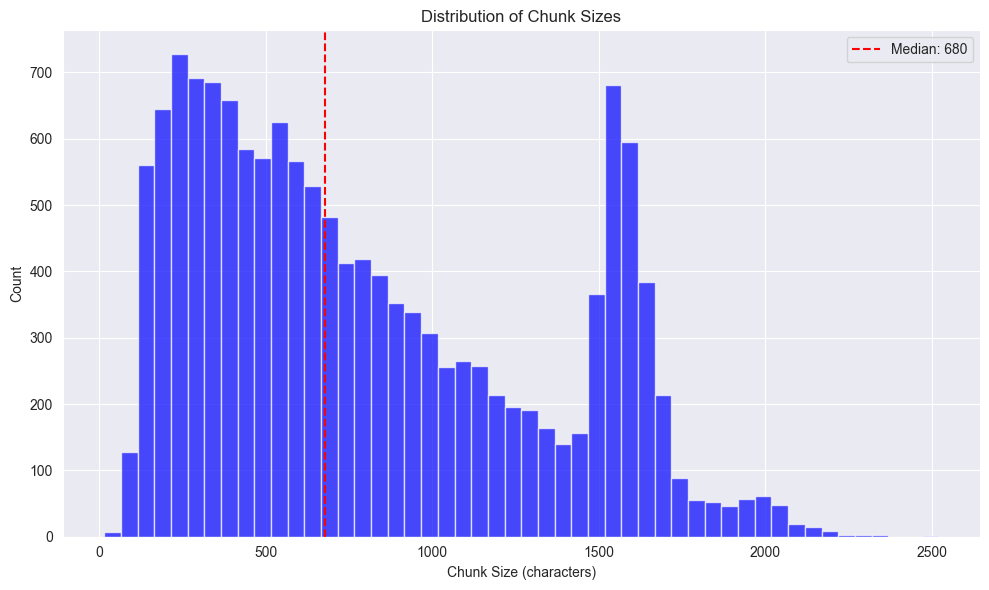

In [2]:
import pandas as pd
import numpy as np
import re
from typing import List, Dict, Tuple
import nltk
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# -------------------------------------------------------------------
# Article Chunker
# -------------------------------------------------------------------
class ArticleChunker:
    """
    Chunks long articles into meaningful segments while preserving context
    """
    
    def __init__(self, 
                 min_chunk_size: int = 500,
                 max_chunk_size: int = 2000,
                 target_chunk_size: int = 1200,
                 overlap_sentences: int = 2):
        """
        Initialize the chunker with configurable parameters
        
        Args:
            min_chunk_size: Minimum characters per chunk
            max_chunk_size: Maximum characters per chunk
            target_chunk_size: Target size for chunks (will vary around this)
            overlap_sentences: Number of sentences to overlap between chunks
        """
        self.min_chunk_size = min_chunk_size
        self.max_chunk_size = max_chunk_size
        self.target_chunk_size = target_chunk_size
        self.overlap_sentences = overlap_sentences
        
    def split_into_sentences(self, text: str) -> List[str]:
        """Split text into sentences using NLTK"""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)
        
        sentences = sent_tokenize(text)
        
        sentences = [s.strip() for s in sentences if len(s.strip()) > 10]
        
        return sentences
    
    def create_chunks_from_sentences(self, sentences: List[str]) -> List[Dict]:
        """Create chunks from sentences with smart boundaries"""
        chunks = []
        current_chunk = []
        current_size = 0
        chunk_start_idx = 0
        
        for i, sentence in enumerate(sentences):
            sentence_size = len(sentence)
            
            if current_size + sentence_size > self.max_chunk_size and current_chunk:
                chunks.append({
                    'text': ' '.join(current_chunk),
                    'start_sentence': chunk_start_idx,
                    'end_sentence': i - 1,
                    'size': current_size
                })
                
                overlap_start = max(0, i - self.overlap_sentences)
                current_chunk = sentences[overlap_start:i]
                current_size = sum(len(s) for s in current_chunk)
                chunk_start_idx = overlap_start
            
            current_chunk.append(sentence)
            current_size += sentence_size
            
            if current_size >= self.target_chunk_size:
                if (sentence.endswith('.') and 
                    i + 1 < len(sentences) and 
                    (sentences[i + 1].startswith(('However', 'Moreover', 'Furthermore', 'In ', 'The ', 'A ')) or
                     len(sentences[i + 1]) > 100)):
                    
                    chunks.append({
                        'text': ' '.join(current_chunk),
                        'start_sentence': chunk_start_idx,
                        'end_sentence': i,
                        'size': current_size
                    })
                    
                    overlap_start = max(0, i + 1 - self.overlap_sentences)
                    current_chunk = sentences[overlap_start:i + 1]
                    current_size = sum(len(s) for s in current_chunk)
                    chunk_start_idx = overlap_start
        
        if current_size >= self.min_chunk_size:
            chunks.append({
                'text': ' '.join(current_chunk),
                'start_sentence': chunk_start_idx,
                'end_sentence': len(sentences) - 1,
                'size': current_size
            })
        elif chunks and current_chunk:
            chunks[-1]['text'] += ' ' + ' '.join(current_chunk)
            chunks[-1]['end_sentence'] = len(sentences) - 1
            chunks[-1]['size'] += current_size
            
        return chunks
    
    def chunk_article(self, text: str, article_id: str = None) -> List[Dict]:
        """
        Chunk a single article into meaningful segments
        
        Args:
            text: The article text to chunk
            article_id: Optional identifier for the article
            
        Returns:
            List of chunk dictionaries with metadata
        """
        if not text or len(text.strip()) < self.min_chunk_size:
            return [{
                'article_id': article_id,
                'chunk_id': 0,
                'text': text.strip(),
                'size': len(text.strip()),
                'total_chunks': 1
            }]
        
        sentences = self.split_into_sentences(text)
        if not sentences:
            return []
        
        chunks = self.create_chunks_from_sentences(sentences)
        
        for i, chunk in enumerate(chunks):
            chunk['article_id'] = article_id
            chunk['chunk_id'] = i
            chunk['total_chunks'] = len(chunks)
            
        return chunks
    
    def chunk_dataframe(self, df: pd.DataFrame, 
                       text_column: str = 'content',
                       id_column: str = None) -> pd.DataFrame:
        """
        Chunk all articles in a dataframe
        
        Args:
            df: DataFrame containing articles
            text_column: Name of column containing article text
            id_column: Name of column containing article IDs (optional)
            
        Returns:
            DataFrame with chunked articles
        """
        all_chunks = []
        
        for idx, row in df.iterrows():
            article_id = row[id_column] if id_column else f"article_{idx}"
            text = row[text_column]
            
            chunks = self.chunk_article(text, article_id)
            
            for chunk in chunks:
                chunk_row = row.to_dict()
                chunk_row.update(chunk)
                chunk_row.pop(text_column, None)
                chunk_row['original_content'] = text[:200] + '...' if len(text) > 200 else text
                all_chunks.append(chunk_row)
        
        return pd.DataFrame(all_chunks)


def analyze_chunk_distribution(df_chunks: pd.DataFrame):
    """Analyze and visualize the distribution of chunk sizes"""
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    df_chunks['size'].hist(bins=50, ax=ax1, alpha=0.7, color='blue')
    ax1.set_xlabel('Chunk Size (characters)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Chunk Sizes')
    ax1.axvline(df_chunks['size'].median(), color='red', linestyle='--', label=f'Median: {df_chunks["size"].median():.0f}')
    ax1.legend()
    plt.tight_layout()
    plt.show()


def chunk_chartering_articles(df_chartering: pd.DataFrame, 
                              analyze: bool = True) -> pd.DataFrame:
    """
    Main function to chunk the chartering articles
    
    Args:
        df_chartering: DataFrame with 'content' column containing article text
        analyze: Whether to show analysis plots
        
    Returns:
        DataFrame with chunked articles
    """
    print(f"Starting chunking process for {len(df_chartering)} articles...")
    
    chunker = ArticleChunker(
        min_chunk_size=500,
        max_chunk_size=3000,
        target_chunk_size=1500,
        overlap_sentences=2
    )
    
    print("\nOriginal article lengths:")
    content_lengths = df_chartering['content'].str.len()
    print(f"Mean: {content_lengths.mean():.0f}, Max: {content_lengths.max()}, Min: {content_lengths.min()}")
    
    df_chunks = chunker.chunk_dataframe(
        df_chartering, 
        text_column='content',
        id_column='title' if 'title' in df_chartering.columns else None
    )
    
    print(f"\nChunking complete!")
    print(f"Created {len(df_chunks)} chunks from {len(df_chartering)} articles")
    print(f"Average chunks per article: {len(df_chunks) / len(df_chartering):.2f}")
    
    if analyze:
        analyze_chunk_distribution(df_chunks)
    
    return df_chunks

df_chunks = chunk_chartering_articles(df_chartering, analyze=True)

In [9]:
df_chunks = df_chunks[df_chunks.text.apply(len) >20]

In [17]:
import os
import re
import json
import time
import pandas as pd
import numpy as np
from google import genai
from datetime import datetime
from typing import List, Dict, Optional, Tuple
import random

from config.logger import CustomLogger
from dotenv import load_dotenv

class NumpyEncoder(json.JSONEncoder):
    """Custom JSON encoder that handles numpy types"""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif pd.isna(obj):
            return None
        return super(NumpyEncoder, self).default(obj)


class MaritimeAnnotationClient:
    """
    Google API client for batch annotating maritime/chartering texts
    """
    
    def __init__(self, df_chunks: pd.DataFrame, text_column: str = 'text'):
        """
        Initialize the annotation client
        
        Args:
            df_chunks: DataFrame containing text chunks to annotate
            text_column: Name of column containing the text to annotate
        """
        self.logger = CustomLogger(name="MaritimeAnnotationClient")
        self.logger.ok("Maritime Annotation Client initialized")
        
        self.df_chunks = df_chunks
        self.text_column = text_column
        self.current_idx = 0
        
        self.indices = list(range(len(df_chunks)))
        random.shuffle(self.indices)
        
        load_dotenv("ENV.txt")
        if not os.getenv("GOOGLE_KEY"):
            self.logger.error("Google API Key not found. Set GOOGLE_KEY in ENV.txt")
            exit(1)
            
        self._client = genai.Client(api_key=os.getenv("GOOGLE_KEY"))
        
        self._setup_directories()
        
        self.annotations = []
        self.failed_chunks = []
        
        self.core_labels = {
            "location": "cities, countries, ports, but non-generic (e.g., 'Port of Rotterdam' = location but 'port' != location)",
            "vessel": "vessel names (e.g., 'MTM Rotterdam' = vessel but 'container ship' != vessel)",
            "incoterm": "trade terms such as FOB, CIF, CFR, EXW, DDP, etc.",
            "commodity": "types of cargo such as gold, corn, wheat, metals, crude oil, coal, etc."
        }
        
    def _setup_directories(self):
        """Setup required directories"""
        try:
            current_dir = os.path.dirname(os.path.abspath(__file__))
        except NameError:
            current_dir = os.getcwd()
            
        repo_root = self._find_repo_root(current_dir)
        self.base_dir = os.path.join(repo_root, "syntheticdata", "maritime_annotations")
        self.output_dir = os.path.join(self.base_dir, "output")
        self.aggregated_dir = os.path.join(self.base_dir, "aggregated")
        
        for dir_path in [self.base_dir, self.output_dir, self.aggregated_dir]:
            os.makedirs(dir_path, exist_ok=True)
            self.logger.info(f"Directory ready: {dir_path}")
            
    def _find_repo_root(self, start_path: str) -> str:
        """Find the repository root directory"""
        current_path = os.path.abspath(start_path)
        
        while True:
            if os.path.basename(current_path) == "Masterthesis-dev":
                return current_path
                
            parent_path = os.path.dirname(current_path)
            if parent_path == current_path:
                return os.getcwd()
                
            current_path = parent_path
            
    def _construct_batch_prompt(self, texts: List[str]) -> str:
        """
        Construct annotation prompt for multiple texts
        
        Args:
            texts: List of texts to annotate
            
        Returns:
            Formatted prompt string
        """
        prompt = f"""
            You are an expert in maritime and chartering terminology. Your task is to identify and extract named entities from multiple texts.
    
            REQUIRED LABELS (must identify all occurrences):
            - **location**: {self.core_labels['location']}
            - **vessel**: {self.core_labels['vessel']}
            - **incoterm**: {self.core_labels['incoterm']}
            - **commodity**: {self.core_labels['commodity']}
            
            For each text, if suitable, select up to 5 additional labels that are most relevant.
            
            TEXTS TO ANNOTATE:
        """
        
        for i, text in enumerate(texts):
            prompt += f"\n[TEXT {i+1}]\n{text}\n"
        
        prompt += """
            INSTRUCTIONS:
            1. For each text, identify all entities that match the required labels
            2. Add up to 5 additional entity types per text if they are prominently featured
            3. Return ONLY an array of arrays in JSON format
            4. Each entity should be in the format: "entity_text <> entity_type"
            5. The outer array should have one inner array for each text, in the same order
            
            OUTPUT FORMAT:
            [
              ["Port of Rotterdam <> location", "FOB <> incoterm"],
              ["MTM Singapore <> vessel", "crude oil <> commodity"],
              ...
            ]

            Return ONLY the JSON array of arrays with the extracted entities.
        """

        return prompt
        
    def _submit_prompt(self, prompt: str, model: str = "gemini-2.0-flash") -> str:
        """Submit prompt to API with retry logic"""
        max_retries = 5
        delay = 2
        
        for attempt in range(max_retries):
            try:
                response = self._client.models.generate_content(
                    model=model,
                    contents=prompt
                )
                return response.text
            except Exception as e:
                if attempt < max_retries - 1:
                    self.logger.warning(f"Attempt {attempt + 1} failed. Retrying in {delay} seconds...")
                    time.sleep(delay)
                    delay *= 2
                else:
                    raise e
                    
    def _parse_batch_response(self, response: str) -> List[List[str]]:
        """Parse batch API response to extract entities for each text"""
        try:
            response = response.strip()
            if response.startswith("```json"):
                response = response[7:]
            if response.startswith("```"):
                response = response[3:]
            if response.endswith("```"):
                response = response[:-3]
            response = response.strip()
            
            batch_entities = json.loads(response)
            
            if isinstance(batch_entities, list):
                valid_batch = []
                for entities in batch_entities:
                    if isinstance(entities, list):
                        valid_entities = []
                        for entity in entities:
                            if isinstance(entity, str) and " <> " in entity:
                                valid_entities.append(entity)
                        valid_batch.append(valid_entities)
                    else:
                        valid_batch.append([])
                return valid_batch
            return []
            
        except json.JSONDecodeError:
            self.logger.error(f"Failed to parse batch response: {response[:200]}...")
            return []
            
    def _get_batch(self, batch_size: int) -> Tuple[List[int], List[str], List[pd.Series]]:
        """Get a batch of texts to annotate"""
        batch_indices = []
        batch_texts = []
        batch_data = []
        
        for _ in range(batch_size):
            if self.current_idx >= len(self.indices):
                self.current_idx = 0
                random.shuffle(self.indices)
                
            if self.current_idx < len(self.indices):
                idx = self.indices[self.current_idx]
                chunk_data = self.df_chunks.iloc[idx]
                text = chunk_data[self.text_column]
                
                batch_indices.append(idx)
                batch_texts.append(text)
                batch_data.append(chunk_data)
                
                self.current_idx += 1
            else:
                break
                
        return batch_indices, batch_texts, batch_data
            
    def annotate_chunks(self, num_chunks: int = 1000, batch_size: int = 50, save_every: int = 100) -> pd.DataFrame:
        """
        Annotate specified number of chunks in batches
        
        Args:
            num_chunks: Total number of chunks to annotate
            batch_size: Number of chunks to process in each API call
            save_every: Save progress every N chunks
            
        Returns:
            DataFrame with annotations
        """
        self.logger.info(f"Starting annotation of {num_chunks} chunks in batches of {batch_size}...")
        start_time = time.time()
        chunks_processed = 0
        
        while chunks_processed < num_chunks:
            current_batch_size = min(batch_size, num_chunks - chunks_processed)
            
            batch_indices, batch_texts, batch_data = self._get_batch(current_batch_size)
            
            if not batch_texts:
                self.logger.warning("No more chunks to process")
                break
                
            try:
                prompt = self._construct_batch_prompt(batch_texts)
                response = self._submit_prompt(prompt)
                batch_entities = self._parse_batch_response(response)
                
                results_to_process = min(len(batch_indices), len(batch_entities) if batch_entities else 0)
                
                for i in range(results_to_process):
                    idx = batch_indices[i]
                    entities = batch_entities[i] if i < len(batch_entities) else []
                    chunk_data = batch_data[i]
                    
                    if 'size' in chunk_data:
                        chunk_size = int(chunk_data.get('size'))
                    else:
                        chunk_size = len(batch_texts[i]) if i < len(batch_texts) else 0
                    
                    annotation = {
                        'chunk_idx': int(idx),
                        'article_id': str(chunk_data.get('article_id', '')),
                        'chunk_id': int(chunk_data.get('chunk_id', 0)),
                        'chunk_size': chunk_size,
                        'entities': entities,
                        'num_entities': len(entities),
                        'timestamp': datetime.now().isoformat(),
                        'batch_id': f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{chunks_processed//batch_size}"
                    }
                    
                    self.annotations.append(annotation)
                
                if results_to_process < len(batch_indices):
                    for i in range(results_to_process, len(batch_indices)):
                        self.failed_chunks.append({
                            'chunk_idx': int(batch_indices[i]),
                            'error': 'No result returned from API',
                            'timestamp': datetime.now().isoformat()
                        })
                
                chunks_processed += len(batch_indices)
                
                elapsed = time.time() - start_time
                rate = chunks_processed / elapsed if elapsed > 0 else 0
                self.logger.info(f"Progress: {chunks_processed}/{num_chunks} chunks ({rate:.2f} chunks/sec)")
                
                if batch_entities and batch_entities[0]:
                    self.logger.info(f"Sample entities from batch: {batch_entities[0][:3]}")
                    
            except Exception as e:
                self.logger.error(f"Error processing batch: {e}")
                for idx in batch_indices:
                    self.failed_chunks.append({
                        'chunk_idx': int(idx),
                        'error': str(e),
                        'timestamp': datetime.now().isoformat()
                    })
                    
            if chunks_processed % save_every == 0 or chunks_processed >= num_chunks:
                self._save_progress()
                
            if chunks_processed % (15 * batch_size) == 0 and chunks_processed < num_chunks:
                self.logger.info("Rate limit pause (60 seconds)...")
                time.sleep(60)
                
        self._save_progress()
        
        df_results = pd.DataFrame(self.annotations)
        
        total_time = time.time() - start_time
        self.logger.ok(f"\nAnnotation complete!")
        self.logger.info(f"Total chunks processed: {len(self.annotations)}")
        self.logger.info(f"Failed chunks: {len(self.failed_chunks)}")
        self.logger.info(f"Total time: {total_time/60:.2f} minutes")
        
        if len(self.annotations) > 0:
            self.logger.info(f"Average time per chunk: {total_time/len(self.annotations):.2f} seconds")
            self.logger.info(f"Processing rate: {len(self.annotations)/total_time:.2f} chunks/second")
        
        if len(df_results) > 0:
            entity_counts = {}
            for entities in df_results['entities']:
                for entity in entities:
                    if ' <> ' in entity:
                        entity_type = entity.split(' <> ')[1]
                        entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
                        
            self.logger.info("\nEntity type distribution:")
            for entity_type, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
                self.logger.info(f"  {entity_type}: {count}")
                
        return df_results
        
    def _save_progress(self):
        """Save current annotations to file"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        if self.annotations:
            output_file = os.path.join(self.output_dir, f'annotations_{timestamp}.json')
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(self.annotations, f, indent=2, ensure_ascii=False, cls=NumpyEncoder)
            self.logger.info(f"Saved {len(self.annotations)} annotations to {output_file}")
            
        if self.failed_chunks:
            failed_file = os.path.join(self.output_dir, f'failed_{timestamp}.json')
            with open(failed_file, 'w', encoding='utf-8') as f:
                json.dump(self.failed_chunks, f, indent=2, cls=NumpyEncoder)
            self.logger.info(f"Saved {len(self.failed_chunks)} failed chunks to {failed_file}")
            
    def aggregate_results(self) -> pd.DataFrame:
        """Aggregate all annotation files into a single DataFrame"""
        all_annotations = []
        
        for filename in os.listdir(self.output_dir):
            if filename.startswith('annotations_') and filename.endswith('.json'):
                file_path = os.path.join(self.output_dir, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        annotations = json.load(f)
                        all_annotations.extend(annotations)
                except Exception as e:
                    self.logger.error(f"Error reading {file_path}: {e}")
                    
        seen_chunks = set()
        unique_annotations = []
        for ann in all_annotations:
            if ann['chunk_idx'] not in seen_chunks:
                seen_chunks.add(ann['chunk_idx'])
                unique_annotations.append(ann)
                
        aggregated_file = os.path.join(self.aggregated_dir, 'all_annotations.json')
        with open(aggregated_file, 'w', encoding='utf-8') as f:
            json.dump(unique_annotations, f, indent=2, ensure_ascii=False, cls=NumpyEncoder)
            
        self.logger.ok(f"Aggregated {len(unique_annotations)} unique annotations")
        self.logger.info(f"Saved to: {aggregated_file}")
        
        return pd.DataFrame(unique_annotations)


def annotate_maritime_corpus(df_chunks: pd.DataFrame, 
                           num_chunks: int = 1000,
                           batch_size: int = 50,
                           text_column: str = 'text') -> pd.DataFrame:
    """
    Main function to annotate maritime corpus in batches
    
    Args:
        df_chunks: DataFrame with chunked texts
        num_chunks: Number of chunks to annotate
        batch_size: Number of chunks per API call
        text_column: Column name containing text
        
    Returns:
        DataFrame with annotations
    """
    client = MaritimeAnnotationClient(df_chunks, text_column)
    
    df_results = client.annotate_chunks(
        num_chunks=num_chunks,
        batch_size=batch_size
    )
    
    return df_results


def resume_annotation(df_chunks: pd.DataFrame, 
                     additional_chunks: int = 500,
                     batch_size: int = 50) -> pd.DataFrame:
    """Resume annotation from where it left off"""
    client = MaritimeAnnotationClient(df_chunks)
    
    df_existing = client.aggregate_results()
    
    annotated_indices = set(df_existing['chunk_idx'].values)
    client.indices = [idx for idx in client.indices if idx not in annotated_indices]
    
    if not client.indices:
        print("All chunks have been annotated!")
        return df_existing
        
    print(f"Resuming annotation. {len(client.indices)} chunks remaining.")
    
    df_new = client.annotate_chunks(
        num_chunks=min(additional_chunks, len(client.indices)),
        batch_size=batch_size
    )
    
    return client.aggregate_results()

In [19]:
df_annotations = annotate_maritime_corpus(df_chunks, num_chunks=14219, batch_size=80)

| 2025-06-18 11:06:07 | :: | OK      | :: | Maritime Annotation Client initialized                                                                                                                                                          
| 2025-06-18 11:06:07 | :: | INFO    | :: | Directory ready: C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\syntheticdata\maritime_annotations                                                                 
| 2025-06-18 11:06:07 | :: | INFO    | :: | Directory ready: C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\syntheticdata\maritime_annotations\output                                                          
| 2025-06-18 11:06:07 | :: | INFO    | :: | Directory ready: C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\syntheticdata\maritime_annotations\aggregated                                                      
| 2025-06-18 11:06:07 | :: | INFO    | :: | Starting

In [28]:
import json
import pandas as pd
import os
from typing import Dict, List, Tuple, Optional


def analyze_annotation_structure(annotations_path: str) -> Dict:
    """Analyze the structure of annotations to understand the indexing"""
    
    with open(annotations_path, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    
    print(f"Total annotations: {len(annotations)}")
    
    if annotations:
        sample = annotations[0]
        print(f"\nAvailable fields in annotations: {list(sample.keys())}")
        
        chunk_indices = [ann['chunk_idx'] for ann in annotations]
        print(f"\nChunk indices range: {min(chunk_indices)} to {max(chunk_indices)}")
        print(f"Unique chunk indices: {len(set(chunk_indices))}")
        
        if len(chunk_indices) != len(set(chunk_indices)):
            print("WARNING: Duplicate chunk indices found!")
            
        if 'article_id' in sample:
            unique_articles = len(set(ann.get('article_id', '') for ann in annotations))
            print(f"Unique article IDs: {unique_articles}")
            
    return {
        'total': len(annotations),
        'indices': chunk_indices if annotations else []
    }


def validate_chunk_match(chunk_text: str, entities: List[str], threshold: float = 0.1) -> bool:
    """
    Validate if entities actually match the chunk text
    
    Args:
        chunk_text: The text of the chunk
        entities: List of entities in "text <> type" format
        threshold: Minimum percentage of entities that should be found in text
        
    Returns:
        bool: True if match seems valid
    """
    
    if not entities:
        return True
        
    chunk_text_lower = chunk_text.lower()
    found_count = 0
    
    for entity in entities:
        if " <> " in entity:
            entity_text, entity_type = entity.split(" <> ", 1)
            if entity_text.lower() in chunk_text_lower:
                found_count += 1
                
    match_ratio = found_count / len(entities) if entities else 0
    return match_ratio >= threshold


def combine_annotations_with_chunks_safe(df_chunks: pd.DataFrame, 
                                       annotations_path: str, 
                                       text_column: str = 'text',
                                       validate: bool = True) -> List[Dict]:
    """
    Safely combine annotations with chunks with validation
    
    Args:
        df_chunks: DataFrame with text chunks
        annotations_path: Path to annotations JSON
        text_column: Column name containing text
        validate: Whether to validate matches
        
    Returns:
        List of combined entries
    """
    
    print("Analyzing annotation structure...")
    ann_info = analyze_annotation_structure(annotations_path)
    
    with open(annotations_path, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    
    print(f"\nDataFrame info:")
    print(f"Total rows: {len(df_chunks)}")
    print(f"Index range: {df_chunks.index.min()} to {df_chunks.index.max()}")
    print(f"Index is unique: {df_chunks.index.is_unique}")
    
    combined_data = []
    matched_count = 0
    mismatched_count = 0
    validation_failed = 0
    
    print("\nTrying direct index matching...")
    
    idx_to_entities = {}
    for ann in annotations:
        chunk_idx = ann['chunk_idx']
        entities = ann.get('entities', [])
        idx_to_entities[chunk_idx] = entities
    
    for idx, row in df_chunks.iterrows():
        if idx in idx_to_entities:
            text = row[text_column]
            entities = idx_to_entities[idx]
            
            if validate:
                if validate_chunk_match(text, entities):
                    entry = {
                        "input": text,
                        "output": entities,
                        "chunk_idx": idx
                    }
                    combined_data.append(entry)
                    matched_count += 1
                else:
                    validation_failed += 1
                    if validation_failed <= 5:
                        print(f"\nValidation failed for chunk {idx}:")
                        print(f"Text preview: {text[:100]}...")
                        print(f"Entities: {entities[:3] if len(entities) > 3 else entities}")
            else:
                entry = {
                    "input": text,
                    "output": entities,
                    "chunk_idx": idx
                }
                combined_data.append(entry)
                matched_count += 1
        else:
            mismatched_count += 1
    
    print(f"\nMatching results:")
    print(f"Successfully matched: {matched_count}")
    print(f"No annotation found: {mismatched_count}")
    print(f"Validation failed: {validation_failed}")
    
    if validation_failed > matched_count * 0.1:
        print("\nWARNING: High validation failure rate!")
        print("The annotations might not match the chunks correctly.")
        
        if annotations and 'article_id' in annotations[0] and 'article_id' in df_chunks.columns:
            print("\nTrying to match by article_id and chunk_id...")
            
            combined_data_alt = []
            
            ann_lookup = {}
            for ann in annotations:
                key = (ann.get('article_id'), ann.get('chunk_id'))
                ann_lookup[key] = ann.get('entities', [])
            
            for idx, row in df_chunks.iterrows():
                key = (row.get('article_id'), row.get('chunk_id'))
                if key in ann_lookup:
                    text = row[text_column]
                    entities = ann_lookup[key]
                    
                    if not validate or validate_chunk_match(text, entities):
                        entry = {
                            "input": text,
                            "output": entities,
                            "chunk_idx": idx,
                            "article_id": key[0],
                            "chunk_id": key[1]
                        }
                        combined_data_alt.append(entry)
            
            if len(combined_data_alt) > len(combined_data):
                print(f"Alternative matching found {len(combined_data_alt)} matches (vs {len(combined_data)})")
                combined_data = combined_data_alt
    
    return combined_data


def create_training_dataset_safe(df_chunks: pd.DataFrame, 
                               annotations_path: str, 
                               output_dir: str = None,
                               text_column: str = 'text',
                               validate: bool = True) -> List[Dict]:
    """
    Create training dataset with validation
    
    Args:
        df_chunks: DataFrame with chunks
        annotations_path: Path to annotations
        output_dir: Output directory
        text_column: Text column name
        validate: Whether to validate matches
        
    Returns:
        Combined training data
    """
    
    combined_data = combine_annotations_with_chunks_safe(
        df_chunks, annotations_path, text_column, validate
    )
    
    if not combined_data:
        print("\nERROR: No valid matches found!")
        print("Possible issues:")
        print("1. The chunk indices in annotations don't match DataFrame indices")
        print("2. The annotations are from a different dataset")
        print("3. The DataFrame index has been reset or modified")
        return []
    
    if output_dir is None:
        output_dir = os.path.dirname(annotations_path)
    
    output_path = os.path.join(output_dir, 'training_data_validated.json')
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(combined_data, f, indent=2, ensure_ascii=False)
    
    print(f"\nSaved {len(combined_data)} validated entries to {output_path}")
    
    print(f"\nDataset Statistics:")
    print(f"Total examples: {len(combined_data)}")
    
    entity_counts = {}
    total_entities = 0
    empty_outputs = 0
    
    for entry in combined_data:
        if not entry['output']:
            empty_outputs += 1
            
        for entity in entry['output']:
            total_entities += 1
            if ' <> ' in entity:
                entity_type = entity.split(' <> ')[1]
                entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
    
    print(f"Total entities: {total_entities}")
    print(f"Average entities per text: {total_entities/len(combined_data):.2f}")
    print(f"Entries with no entities: {empty_outputs}")
    
    print("\nEntity type distribution:")
    for entity_type, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"  {entity_type}: {count}")
    
    print("\n" + "="*60)
    print("SAMPLE ENTRIES FOR VERIFICATION")
    print("="*60)
    
    examples_shown = 0
    for entry in combined_data:
        if entry['output'] and examples_shown < 3:
            print(f"\nExample {examples_shown + 1}:")
            print(f"Text: {entry['input'][:200]}...")
            print(f"Entities:")
            for entity in entry['output'][:5]:
                print(f"  - {entity}")
            examples_shown += 1
            print("-"*60)
    
    return combined_data


def diagnose_mismatch(df_chunks: pd.DataFrame, annotations_path: str):
    """Diagnose why annotations might not match chunks"""
    
    print("="*60)
    print("DIAGNOSTIC REPORT")
    print("="*60)
    
    with open(annotations_path, 'r', encoding='utf-8') as f:
        annotations = json.load(f)
    
    if not annotations:
        print("ERROR: No annotations found!")
        return
    
    sample_ann = annotations[0]
    print(f"\nSample annotation structure:")
    for key, value in sample_ann.items():
        if key != 'entities':
            print(f"  {key}: {value}")
    print(f"  entities: {len(sample_ann.get('entities', []))} items")
    
    chunk_idx = sample_ann['chunk_idx']
    print(f"\nLooking for chunk index {chunk_idx} in DataFrame...")
    
    if chunk_idx in df_chunks.index:
        chunk_row = df_chunks.loc[chunk_idx]
        print("✓ Found chunk in DataFrame")
        
        if 'article_id' in sample_ann and 'article_id' in df_chunks.columns:
            if str(chunk_row.get('article_id', '')) == str(sample_ann['article_id']):
                print("✓ article_id matches")
            else:
                print(f"✗ article_id mismatch: DataFrame has '{chunk_row.get('article_id')}', annotation has '{sample_ann['article_id']}'")
                
    else:
        print(f"✗ Chunk index {chunk_idx} NOT found in DataFrame")
        print(f"  DataFrame index range: {df_chunks.index.min()} to {df_chunks.index.max()}")
        
        if 'article_id' in sample_ann and 'article_id' in df_chunks.columns:
            matching_rows = df_chunks[
                (df_chunks['article_id'] == sample_ann['article_id']) & 
                (df_chunks['chunk_id'] == sample_ann.get('chunk_id', -1))
            ]
            if len(matching_rows) > 0:
                print(f"\n  But found matching article_id/chunk_id at DataFrame index: {matching_rows.index[0]}")
    
    print(f"\nDataFrame index analysis:")
    print(f"  Is monotonic: {df_chunks.index.is_monotonic_increasing}")
    print(f"  Has gaps: {len(df_chunks) != (df_chunks.index.max() - df_chunks.index.min() + 1)}")
    
    print("\nRECOMMENDATION:")
    if chunk_idx not in df_chunks.index:
        print("The DataFrame index doesn't match the annotation chunk_idx.")
        print("Try one of these solutions:")
        print("1. Reset the DataFrame index before annotating")
        print("2. Use article_id + chunk_id for matching instead")
        print("3. Re-run the annotation process with the current DataFrame")


if __name__ == "__main__":
    annotation_path = "../data/wikipedia/wikipedia_annotations.json"
    
    print("Running diagnostics...")
    diagnose_mismatch(df_chunks, annotations_path)
    
    print("\n\nCreating training dataset with validation...")
    training_data = create_training_dataset_safe(
        df_chunks=df_chunks,
        annotations_path=annotations_path,
        text_column='text',
        validate=True
    )

Running diagnostics...
DIAGNOSTIC REPORT

Sample annotation structure:
  chunk_idx: 499
  article_id: Maritime Museum Rotterdam
  chunk_id: 0
  chunk_size: 410
  num_entities: 5
  timestamp: 2025-06-18T11:06:37.927457
  batch_id: 20250618_110637_0
  entities: 5 items

Looking for chunk index 499 in DataFrame...
✓ Found chunk in DataFrame
✓ article_id matches

DataFrame index analysis:
  Is monotonic: True
  Has gaps: True

RECOMMENDATION:


Creating training dataset with validation...
Analyzing annotation structure...
Total annotations: 13825

Available fields in annotations: ['chunk_idx', 'article_id', 'chunk_id', 'chunk_size', 'entities', 'num_entities', 'timestamp', 'batch_id']

Chunk indices range: 0 to 14218
Unique chunk indices: 13825
Unique article IDs: 12001

DataFrame info:
Total rows: 14219
Index range: 0 to 14219
Index is unique: True

Trying direct index matching...

Validation failed for chunk 1:
Text preview: Chartering is an activity within the shipping industry whereby 

In [32]:
# -------------------------------------------------------------------
# Data Loading
# -------------------------------------------------------------------
df_locations = pd.read_csv("../data/port_data/unlocode/unlocode_ports_only_20250604_144152.csv")["Name"]
df_vessels = pd.read_csv("../data/ships_data/imo/imo_vessel_data_cleaned.csv")["name"]

df_locations_blacklisted = pd.read_csv("../data/port_data/shipping_ports_around_the_world/port_data.csv")["Port Name"]
df_vessels_blacklisted = pd.read_csv("../data/ships_data/global_cargo_ships/ships_data.csv")["Company_Name"]

# -------------------------------------------------------------------
# Data Cleaning to Avoid Leakage of Data
# -------------------------------------------------------------------
def normalize_text(text):
    """Normalize text for comparison"""
    if pd.isna(text):
        return ""
    return str(text).lower().strip()

blacklisted_locations_normalized = set(df_locations_blacklisted.apply(normalize_text))
blacklisted_vessels_normalized = set(df_vessels_blacklisted.apply(normalize_text))

clean_locations = df_locations[~df_locations.apply(normalize_text).isin(blacklisted_locations_normalized)].dropna().unique()
clean_vessels = df_vessels[~df_vessels.apply(normalize_text).isin(blacklisted_vessels_normalized)].dropna().unique()

print(f"Clean locations: {len(clean_locations)} (removed {len(df_locations) - len(clean_locations)})")
print(f"Clean vessels: {len(clean_vessels)} (removed {len(df_vessels) - len(clean_vessels)})")

Clean locations: 13966 (removed 624)
Clean vessels: 10798 (removed 22)


In [43]:
import random
import re
from datetime import datetime, timedelta
from collections import defaultdict
from tqdm import tqdm
import json

# =============================================================================
# ENTITY LISTS AND CONSTANTS
# =============================================================================

# Expanded INCOTERMS with variations
INCOTERMS = [
    "FOB", "CIF", "CFR", "EXW", "FCA", "CPT", "CIP", "DAP", "DPU", "DDP",
    "FAS", "DAT", "DEQ", "DES", "DDU", "CNF", "C&F", "CRF"
]

# Comprehensive commodities list
COMMODITIES = [
    # Dry bulk
    "iron ore", "coal", "grain", "wheat", "corn", "soybeans", "barley", "rice", 
    "sugar", "salt", "fertilizer", "cement", "bauxite", "alumina", "manganese ore",
    "nickel ore", "copper concentrate", "zinc concentrate", "lead concentrate",
    "limestone", "clinker", "gypsum", "aggregates", "sand", "gravel",
    
    # Minor bulk
    "steel products", "steel coils", "steel plates", "steel billets", "rebar",
    "aluminum ingots", "copper cathodes", "zinc slabs", "lead ingots",
    "timber", "logs", "plywood", "wood chips", "wood pellets", "paper products",
    "scrap metal", "pig iron", "DRI/HBI", "ferro alloys", "coke", "pet coke",
    
    # Liquid bulk
    "crude oil", "gasoline", "diesel", "jet fuel", "fuel oil", "naphtha",
    "LNG", "LPG", "condensate", "bitumen", "lubricants", "base oil",
    "methanol", "ethanol", "ammonia", "caustic soda", "sulphuric acid",
    "palm oil", "soybean oil", "sunflower oil", "vegetable oil", "molasses",
    
    # Containers/General
    "machinery", "equipment", "auto parts", "vehicles", "electronics",
    "textiles", "garments", "footwear", "furniture", "appliances",
    "chemicals", "plastics", "rubber", "pharmaceuticals", "medical supplies",
    "frozen meat", "frozen fish", "frozen food", "fresh produce", "fruits",
    
    # Agricultural
    "coffee beans", "cocoa beans", "tea", "cotton", "tobacco", "nuts",
    "pulses", "lentils", "chickpeas", "beans", "seeds", "animal feed",
    "hay", "straw", "palm kernel", "copra", "tapioca", "cassava",
    
    # Specialized
    "project cargo", "wind turbines", "transformers", "generators",
    "reactors", "pressure vessels", "pipes", "modules", "heavy machinery",
    "yachts", "boats", "containers", "dangerous goods", "military cargo",
    "humanitarian aid", "relief supplies", "personal effects", "household goods"
]

# Vessel prefixes
VESSEL_PREFIXES = ["MV", "MT", "MS", "SS", "M/V", "M/T"]

# Quantity units
QUANTITY_UNITS = ["MT", "metric tons", "tons", "tonnes", "CBM", "TEU", "FEU", 
                  "barrels", "gallons", "liters", "cubic meters", "units"]

# Additional missing constants
COUNTRIES = [
    "China", "USA", "Japan", "Germany", "UK", "France", "Italy", "Spain",
    "South Korea", "India", "Brazil", "Russia", "Canada", "Australia",
    "Netherlands", "Belgium", "Norway", "Denmark", "Sweden", "Finland"
]

# Time-related terms
TIME_TERMS = ["prompt", "early", "mid", "late", "end", "beginning", "first half", "second half"]
MONTHS = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

# Quality descriptors
QUALITY_TERMS = ["prime", "standard", "off-spec", "contaminated", "wet", "dry", "clean", "dirty"]

# Companies and terminals
SHIPPING_COMPANIES = ["Charterer A", "Shipper B", "Trader C", "Operator D", "Owner E", 
                      "Freight Co", "Global Shipping", "Maritime Corp", "Ocean Lines", "Pacific Traders"]
TERMINAL_OPERATORS = ["Terminal 1", "Berth A", "Wharf B", "Pier C", "Jetty D",
                      "Container Terminal", "Bulk Terminal", "Oil Terminal"]

# =============================================================================
# FIXED GENERATOR CLASS
# =============================================================================

class FixedMaritimeGenerator:
    def __init__(self, vessels_list=None, locations_list=None):
        """Initialize generator with optional custom vessel and location lists"""
        self.vessels = vessels_list if vessels_list else ["Vessel Alpha", "Vessel Beta", "Vessel Gamma"]
        self.locations = locations_list if locations_list else ["Singapore", "Rotterdam", "Houston"]
        
        self.template_categories = {
            'incoterm_focused':     self._incoterm_focused_templates(),
            'commodity_focused':    self._commodity_focused_templates(),
            'trade_terms':          self._trade_terms_templates(),
            'multi_commodity':      self._multi_commodity_templates(),
            'voyage':               self._voyage_templates(),
            'commercial':           self._commercial_templates(),
            'operations':           self._operations_templates(),
            'logistics':            self._logistics_templates()
        }
        
    def _incoterm_focused_templates(self):
        """Templates specifically designed to highlight incoterms"""
        return [
            # Basic incoterm usage
            "The {commodity} shipment was sold {incoterm} {location} with buyer arranging onward transport.",
            "Under {incoterm} terms, seller delivers {commodity} to {vessel} at {location} port.",
            "The {incoterm} price for {commodity} includes freight to {location} but not insurance.",
            "{company} quoted {quantity} {unit} of {commodity} at ${price} per ton {incoterm} {location}.",
            "Risk transfer for {commodity} occurs when goods pass ship's rail under {incoterm} terms at {location}.",
            
            # Incoterm comparisons
            "Buyer preferred {incoterm1} {location1} over {incoterm2} {location2} for {commodity} purchase.",
            "The {commodity} deal shifted from {incoterm1} to {incoterm2} terms affecting price by ${price} per {unit}.",
            "Insurance responsibility differs between {incoterm1} and {incoterm2} for {commodity} shipments to {location}.",
            "{vessel} carries {commodity} under both {incoterm1} and {incoterm2} terms from {location}.",
            "Cost comparison shows {incoterm1} saves ${price} versus {incoterm2} for {commodity} to {location}.",
            
            # Detailed incoterm scenarios
            "The {incoterm} contract requires seller to load {commodity} on {vessel} and pay freight to {location}.",
            "Under {incoterm} {location}, buyer bears all risks once {commodity} is alongside {vessel}.",
            "{company} fulfilled {incoterm} obligations by delivering {commodity} to carrier at {location} terminal.",
            "The {incoterm} terms make seller responsible for {commodity} until delivery at {location} buyer's premises.",
            "Export clearance for {commodity} under {incoterm} terms completed by seller at {location}.",
            
            # Multiple incoterms
            "{company} offers {commodity} {incoterm1} {location1} at ${price1} or {incoterm2} {location2} at ${price2}.",
            "Split shipment of {commodity}: {quantity1} {unit} {incoterm1} and {quantity2} {unit} {incoterm2} via {location}.",
            "The {commodity} tender allows bidding on {incoterm1}, {incoterm2}, or {incoterm3} basis to {location}.",
            "{vessel} manifest shows {commodity} parcels under {incoterm1}, {incoterm2}, and {incoterm3} terms.",
            
            # Time-sensitive incoterm scenarios
            "Urgent {commodity} shipment requires {incoterm} {location} delivery by {date} on {vessel}.",
            "The {incoterm} contract for {commodity} stipulates Q{quarter} delivery to {location}.",
            "Seller must ship {commodity} {incoterm} within {days} days of L/C opening for {location} delivery.",
            "{company} exercised option for additional {commodity} at same {incoterm} terms before {date}."
        ]
        
    def _commodity_focused_templates(self):
        """Templates emphasizing commodities"""
        return [
            # Basic commodity movements
            "{vessel} loaded {quantity} {unit} of {commodity} at {location} for discharge at {location2}.",
            "The {commodity} cargo requires special handling due to its {quality_term} condition at {location}.",
            "{company} trades {commodity1}, {commodity2}, and {commodity3} from {location} globally.",
            "Premium {quality_term} {commodity} commanded ${price} per {unit} above standard grade at {location}.",
            
            # Multi-commodity scenarios
            "{vessel} carries combination of {commodity1} in holds 1-3 and {commodity2} in holds 4-5 to {location}.",
            "Cargo manifest lists {commodity1} ({quantity1} {unit}), {commodity2} ({quantity2} {unit}), and {commodity3} for {location}.",
            "The {commodity1}/{commodity2} ratio optimizes {vessel} stability on voyage to {location}.",
            "Compatible stowage allows {commodity1} adjacent to {commodity2} on {vessel} to {location}.",
            
            # Commodity specifications
            "The {commodity} shipment meets specification with moisture content below {number}% for {location} delivery.",
            "{quality_term} grade {commodity} with high purity loaded on {vessel} at {location}.",
            "{company} guarantees {commodity} quality for {incoterm} {location} delivery.",
            
            # Commodity pricing/trading
            "Spot {commodity} trades at ${price} {incoterm} {location}, up ${price_change} from last week.",
            "The {commodity} arbitrage between {location1} and {location2} widened to ${price} per {unit}.",
            "Forward sales of {commodity} for {month} delivery {incoterm} {location} closed at ${price}.",
            
            # Seasonal commodity patterns
            "Peak {commodity} season drives demand for {vessel_type} tonnage at {location}.",
            "Off-season {commodity} shipments from {location} offer freight rate advantages on {vessel}.",
            "The {commodity} harvest at {location} region begins {month}, affecting shipping schedules.",
            
            # Commodity logistics
            "The {commodity} supply chain from {location1} involves transport to {location2} for {vessel} loading.",
            "{commodity} requires fumigation at {location} before loading on {vessel} for {location2}.",
            "Dedicated {commodity} terminal at {location} handles {quantity} {unit} annually via vessels like {vessel}."
        ]
        
    def _trade_terms_templates(self):
        """Templates combining incoterms with commodity trades"""
        return [
            # Complex trade structures
            "The {commodity} sale involves {incoterm1} {location1} for main cargo and {incoterm2} {location2} for optional quantity.",
            "{company} structured {commodity} deal: buy {incoterm1} {location1}, sell {incoterm2} {location2} capturing ${price} margin.",
            "Three-way trade: {commodity} purchased {incoterm1} {location1}, shipped via {location2}, sold {incoterm2} {location3}.",
            
            # Incoterm-specific commodity requirements
            "The {incoterm} terms for {commodity} specify seller provides documentation at {location}.",
            "Under {incoterm} {location}, {commodity} quality inspection occurs before risk transfer to buyer.",
            "{commodity} sold {incoterm} requires seller to arrange inspection at {location} load port.",
            
            # Regional trade patterns
            "Asian buyers prefer {incoterm} terms for {commodity} imports through {location} distribution hub.",
            "The {location} {commodity} market standard is {incoterm} pricing with {payment_term} payment terms.",
            
            # Financial aspects
            "LC terms for {commodity} specify {incoterm} {location} with {number} days usance from B/L date.",
            "The {incoterm} price includes {commodity} financing cost during {days}-day voyage to {location}.",
            "Prepayment discount available for {commodity} purchased {incoterm} {location} reducing price by {number}%."
        ]
        
    def _multi_commodity_templates(self):
        """Templates featuring multiple commodities"""
        return [
            # Cargo combinations
            "{vessel} loads {commodity1} ({quantity1} {unit}), {commodity2} ({quantity2} {unit}), and {commodity3} at {location}.",
            "The {location} terminal simultaneously handles {commodity1} imports and {commodity2}/{commodity3} exports.",
            "Backhaul opportunity: {vessel} discharges {commodity1} at {location1}, loads {commodity2} for {location2}.",
            
            # Commodity swaps/exchanges
            "{company} swaps {commodity1} at {location1} for {commodity2} at {location2} balancing regional needs.",
            "The commodity exchange involves {quantity1} {unit} {commodity1} for {quantity2} {unit} {commodity2} {incoterm} {location}.",
            
            # Processing chains
            "{location} refinery converts {commodity1} feedstock to {commodity2} and {commodity3} for export on {vessel}.",
            "The {commodity1} delivered {incoterm} {location} yields {quantity} {unit} of {commodity2} product.",
            
            # Seasonal transitions
            "{vessel} switches from {commodity1} in summer to {commodity2} in winter serving {location} route.",
            "The {location} port transitions from {commodity1} exports to {commodity2} imports as seasons change."
        ]
        
    def _voyage_templates(self):
        """Voyage-related templates"""
        return [
            # Basic voyages
            "{vessel} departed from {location1} bound for {location2} carrying {quantity} {unit} of {commodity}.",
            "The {vessel} is scheduled to arrive at {location} on {date} with a cargo of {commodity}.",
            "{vessel} completed loading {quantity} {unit} of {commodity} at {location} and sailed for {location2}.",
            
            # Voyage planning
            "{vessel} voyage plan optimizes fuel consumption carrying {commodity} {incoterm} from {location1} to {location2}.",
            "The {commodity}-laden {vessel} routes via {location1} to avoid weather, adding {days} days to {incoterm} delivery.",
            
            # Complex patterns
            "{vessel} triangular voyage: ballast to {location1}, load {commodity1} for {location2}, then {commodity2} to {location3}.",
            "Backhaul cargo of {commodity2} from {location2} improves {vessel} economics after {commodity1} discharge at {location1}."
        ]
        
    def _commercial_templates(self):
        """Commercial and trading templates"""
        return [
            # Trading strategies
            "{company} arbitrages {commodity} between {location1} {incoterm1} and {location2} {incoterm2} markets using {vessel}.",
            "Physical {commodity} premium over paper drives {company} to fix {vessel} for prompt {location} loading.",
            
            # Contract negotiations
            "{company} negotiates {commodity} volume discount: {quantity1} {unit} at ${price1}, {quantity2} {unit} at ${price2} {incoterm} {location}.",
            "Take-or-pay {commodity} contract requires {quantity} {unit} monthly liftings {incoterm} {location} on vessels like {vessel}.",
            
            # Market intelligence
            "{vessel} fixtures for {commodity} indicate tightening freight market ex {location} for {month} positions.",
            "The {commodity} cargo flow data shows {percentage}% increase from {location1} to {location2} route."
        ]
        
    def _operations_templates(self):
        """Operational templates"""
        return [
            # Port operations
            "{terminal} at {location} handled {vessel} carrying {commodity}.",
            "Stevedoring operations for {commodity} on {vessel} commenced at {location}.",
            "{vessel} required {days} days to discharge {commodity} at {location}.",
            
            # Loading/discharge
            "The {commodity} discharge rate from {vessel} at {location} reached {quantity} {unit} per day.",
            "{vessel} uses shore cranes at {location} to load {commodity}.",
            "Night operations for {commodity} on {vessel} approved at {location} terminal."
        ]
        
    def _logistics_templates(self):
        """Logistics templates"""
        return [
            # Intermodal
            "Rail delivery of {commodity} to {location} port timed for direct loading onto {vessel} minimizing storage.",
            "The {commodity} moves by barge to {location1} for transshipment to ocean vessel {vessel} bound {location2}.",
            
            # Just-in-time
            "JIT {commodity} delivery coordinates suppliers with {vessel} loading schedule at {location}.",
            "The {vessel} arrival triggers {commodity} release from storage avoiding demurrage at {location}.",
            
            # Technology
            "Blockchain tracks {commodity} from origin through {vessel} voyage to final {location} delivery {incoterm}.",
            "IoT sensors monitor {commodity} condition during inland transport and {vessel} voyage to {location}."
        ]
        
    def _generate_random_values(self):
        """Generate random values for template filling"""
        return {
            'vessel': self._get_random_vessel(),
            'vessel1': self._get_random_vessel(),
            'vessel2': self._get_random_vessel(),
            'location': self._get_random_location(),
            'location1': self._get_random_location(),
            'location2': self._get_random_location(), 
            'location3': self._get_random_location(),
            'commodity': self._get_random_commodity(),
            'commodity1': self._get_random_commodity(),
            'commodity2': self._get_random_commodity(),
            'commodity3': self._get_random_commodity(),
            'incoterm': self._get_random_incoterm(),
            'incoterm1': self._get_random_incoterm(),
            'incoterm2': self._get_random_incoterm(),
            'incoterm3': self._get_random_incoterm(),
            'quantity': random.randint(5000, 200000),
            'quantity1': random.randint(5000, 100000),
            'quantity2': random.randint(5000, 100000),
            'unit': random.choice(QUANTITY_UNITS),
            'price': random.randint(10, 1000),
            'price1': random.randint(10, 500),
            'price2': random.randint(10, 500),
            'price_change': random.randint(1, 50),
            'percentage': random.randint(1, 100),
            'number': random.randint(1, 100),
            'days': random.randint(1, 90),
            'months': random.randint(1, 12),
            'date': self._generate_random_date(),
            'month': random.choice(MONTHS),
            'quarter': random.randint(1, 4),
            'company': random.choice(SHIPPING_COMPANIES),
            'terminal': random.choice(TERMINAL_OPERATORS),
            'quality_term': random.choice(QUALITY_TERMS),
            'vessel_type': random.choice(['Capesize', 'Panamax', 'Supramax', 'Handysize']),
            'payment_term': random.choice(['LC at sight', '30 days', 'CAD', 'TT']),
            'country': random.choice(COUNTRIES)
        }
        
    def _get_random_vessel(self):
        """Get random vessel with prefix"""
        vessel = random.choice(self.vessels)
        if random.random() < 0.7:
            prefix = random.choice(VESSEL_PREFIXES)
            return f"{prefix} {vessel}"
        return vessel
        
    def _get_random_location(self):
        """Get random location"""
        return random.choice(self.locations)
        
    def _get_random_commodity(self):
        """Get random commodity"""
        return random.choice(COMMODITIES)
        
    def _get_random_incoterm(self):
        """Get random incoterm"""
        return random.choice(INCOTERMS)
        
    def _generate_random_date(self):
        """Generate random date"""
        days_ahead = random.randint(1, 180)
        future_date = datetime.now() + timedelta(days=days_ahead)
        return future_date.strftime("%Y-%m-%d")
        
    def _fill_template(self, template):
        """Fill template with random values"""
        values = self._generate_random_values()
        
        try:
            sentence = template.format(**values)
            return sentence, values
        except KeyError as e:
            print(f"Missing key in template: {e}")
            return None, None
            
    def _extract_entities_from_sentence(self, sentence, context):
        """Extract ONLY entities that actually appear in the sentence"""
        entities = []
        
        entity_mapping = {
            'vessel': 'vessel',
            'vessel1': 'vessel', 
            'vessel2': 'vessel',
            'location': 'location',
            'location1': 'location',
            'location2': 'location',
            'location3': 'location',
            'commodity': 'commodity',
            'commodity1': 'commodity',
            'commodity2': 'commodity',
            'commodity3': 'commodity',
            'incoterm': 'incoterm',
            'incoterm1': 'incoterm',
            'incoterm2': 'incoterm',
            'incoterm3': 'incoterm',
            'company': 'company',
            'terminal': 'company'
        }
        
        seen_entities = set()
        
        for key, value in context.items():
            if key in entity_mapping and isinstance(value, str):
                if value in sentence:
                    entity_text = str(value)
                    entity_type = entity_mapping[key]
                    entity_key = f"{entity_text} <> {entity_type}"
                    
                    if entity_key not in seen_entities:
                        seen_entities.add(entity_key)
                        entities.append(entity_key)
                        
        return list(seen_entities)
        
    def generate_dataset(self, num_samples=20000, min_entities_per_sample=2):
        """Generate dataset with specified number of samples"""
        dataset = []
        category_counts = defaultdict(int)
        failed_attempts = 0
        
        category_weights = {
            'incoterm_focused': 25,
            'commodity_focused': 25,
            'trade_terms': 20,
            'multi_commodity': 15,
            'voyage': 5,
            'commercial': 5,
            'operations': 3,
            'logistics': 2
        }
        
        weighted_categories = []
        for category, weight in category_weights.items():
            weighted_categories.extend([category] * weight)
            
        print(f"Generating {num_samples} maritime sentences...")
        print(f"Using {len(self.vessels)} vessels and {len(self.locations)} locations")
        
        with tqdm(total=num_samples) as pbar:
            while len(dataset) < num_samples:
                category = random.choice(weighted_categories)
                templates = self.template_categories.get(category, [])
                
                if not templates:
                    continue
                    
                template = random.choice(templates)
                sentence, context = self._fill_template(template)
                
                if not sentence:
                    failed_attempts += 1
                    continue
                    
                entities = self._extract_entities_from_sentence(sentence, context)
                
                if len(entities) >= min_entities_per_sample:
                    has_priority_entity = any(
                        'incoterm' in e or 'commodity' in e 
                        for e in entities
                    )
                    
                    if has_priority_entity or random.random() < 0.2:
                        dataset.append({
                            'input': sentence,
                            'output': entities,
                            'category': category
                        })
                        
                        category_counts[category] += 1
                        pbar.update(1)
                        
        print(f"\nGeneration complete! Failed attempts: {failed_attempts}")
        
        self._print_statistics(dataset, category_counts)
        
        return dataset
        
    def _print_statistics(self, dataset, category_counts):
        """Print comprehensive dataset statistics"""
        print("\n" + "="*60)
        print("DATASET STATISTICS")
        print("="*60)
        print(f"Total samples: {len(dataset)}")
        
        print("\nCategory distribution:")
        total_samples = len(dataset)
        for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_samples) * 100
            print(f"  {category}: {count} ({percentage:.1f}%)")
            
        entity_counts = defaultdict(int)
        total_entities = 0
        samples_with_incoterm = 0
        samples_with_commodity = 0
        samples_with_both = 0
        entity_per_sample = []
        
        for item in dataset:
            has_incoterm = False
            has_commodity = False
            
            entity_per_sample.append(len(item['output']))
            
            for entity in item['output']:
                total_entities += 1
                entity_type = entity.split(' <> ')[1]
                entity_counts[entity_type] += 1
                
                if entity_type == 'incoterm':
                    has_incoterm = True
                elif entity_type == 'commodity':
                    has_commodity = True
                    
            if has_incoterm:
                samples_with_incoterm += 1
            if has_commodity:
                samples_with_commodity += 1
            if has_incoterm and has_commodity:
                samples_with_both += 1
                
        print(f"\nTotal entities: {total_entities}")
        print(f"Average entities per sample: {total_entities/len(dataset):.2f}")
        print(f"Min entities per sample: {min(entity_per_sample)}")
        print(f"Max entities per sample: {max(entity_per_sample)}")
        
        print("\nEntity type distribution:")
        for entity_type, count in sorted(entity_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / total_entities) * 100
            print(f"  {entity_type}: {count} ({percentage:.1f}%)")
            
        print(f"\nIncoterm/Commodity coverage:")
        print(f"  Samples with incoterms: {samples_with_incoterm} ({samples_with_incoterm/total_samples*100:.1f}%)")
        print(f"  Samples with commodities: {samples_with_commodity} ({samples_with_commodity/total_samples*100:.1f}%)")
        print(f"  Samples with both: {samples_with_both} ({samples_with_both/total_samples*100:.1f}%)")
        
        print("\n" + "="*60)
        print("SAMPLE OUTPUTS")
        print("="*60)
        
        for category in ['incoterm_focused', 'commodity_focused', 'trade_terms']:
            examples = [item for item in dataset if item['category'] == category][:2]
            if examples:
                print(f"\n{category.upper()} examples:")
                for i, example in enumerate(examples):
                    print(f"\n{i+1}. {example['input']}")
                    print(f"   Entities: {example['output']}")


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def generate_maritime_dataset(num_samples=30000, output_path='maritime_ner_dataset.json',
                            vessels_list=None, locations_list=None):
    """
    Generate complete maritime NER dataset
    
    Args:
        num_samples: Number of samples to generate
        output_path: Path to save the dataset
        vessels_list: List of vessel names from your data
        locations_list: List of locations from your data
    """
    
    generator = FixedMaritimeGenerator(
        vessels_list=vessels_list,
        locations_list=locations_list
    )
    
    dataset = generator.generate_dataset(num_samples=num_samples)
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(dataset, f, indent=2, ensure_ascii=False)
        
    print(f"\nDataset saved to: {output_path}")
    
    random.shuffle(dataset)
    split_idx = int(0.9 * len(dataset))
    
    train_data = dataset[:split_idx]
    val_data = dataset[split_idx:]
    
    train_path = output_path.replace('.json', '_train.json')
    val_path = output_path.replace('.json', '_val.json')
    
    with open(train_path, 'w', encoding='utf-8') as f:
        json.dump(train_data, f, indent=2, ensure_ascii=False)
        
    with open(val_path, 'w', encoding='utf-8') as f:
        json.dump(val_data, f, indent=2, ensure_ascii=False)
        
    print(f"Train set ({len(train_data)} samples): {train_path}")
    print(f"Validation set ({len(val_data)} samples): {val_path}")
    
    return dataset

In [44]:
if __name__ == "__main__":
    
    dataset = generate_maritime_dataset(
        num_samples=30000,
        vessels_list=list(clean_vessels),
        locations_list=list(clean_locations)
    )

Generating 30000 maritime sentences...
Using 10798 vessels and 13966 locations


100%|██████████| 30000/30000 [00:01<00:00, 19079.46it/s]



Generation complete! Failed attempts: 0

DATASET STATISTICS
Total samples: 30000

Category distribution:
  incoterm_focused: 7517 (25.1%)
  commodity_focused: 7443 (24.8%)
  trade_terms: 5869 (19.6%)
  multi_commodity: 4542 (15.1%)
  voyage: 1538 (5.1%)
  commercial: 1505 (5.0%)
  operations: 948 (3.2%)
  logistics: 638 (2.1%)

Total entities: 112540
Average entities per sample: 3.75
Min entities per sample: 2
Max entities per sample: 7

Entity type distribution:
  commodity: 39038 (34.7%)
  location: 36247 (32.2%)
  incoterm: 21907 (19.5%)
  vessel: 11507 (10.2%)
  company: 3841 (3.4%)

Incoterm/Commodity coverage:
  Samples with incoterms: 16818 (56.1%)
  Samples with commodities: 30000 (100.0%)
  Samples with both: 16818 (56.1%)

SAMPLE OUTPUTS

INCOTERM_FOCUSED examples:

1. Owner E quoted 162656 CBM of pressure vessels at $547 per ton CPT Bay Bulls.
   Entities: ['CPT <> incoterm', 'pressure vessels <> commodity', 'Owner E <> company', 'Bay Bulls <> location']

2. Buyer preferred